In [0]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
BatchNormalization = tf.compat.v1.layers.batch_normalization

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype('float64') / 255

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float64, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float64, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [0]:
def generator(z, out_dim, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # First layer
        h1 = tf.layers.dense(z, 200, activation=None)
        #  ReLU
        h1 = tf.nn.relu(h1)
        #batch Normalization
        h1 = BatchNormalization(h1)
        # Second layer
        h2 = tf.layers.dense(h1, 400, activation=None)
        #  ReLU
        h2 = tf.nn.relu(h2)
        #batch Normalization
        h2 = BatchNormalization(h2)

        
        # output
        out = tf.layers.dense(h2, out_dim, activation=None)
        
        return out

In [0]:
def discriminator(x,reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First layer
        h1 = tf.layers.dense(x, 400, activation=None)
        #  ReLU
        h1 = tf.nn.relu(h1)
        #batch Normalization
        h1 = BatchNormalization(h1)
        # Second layer
        h2 = tf.layers.dense(h1, 200, activation=None)
        #  ReLU
        h2 = tf.nn.relu(h2)
        #batch Normalization
        h2 = BatchNormalization(h2)
        
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [0]:
# Size of input image to discriminator
input_size = 784
# Size of latent vector to generator
z_size = 100
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

In [0]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size,alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real,alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


In [0]:
# generator losses
D_loss = -0.5*tf.reduce_mean(tf.math.log(d_model_real) + tf.math.log(1.0 - d_model_fake)) #binary crossentropy loss function
G1_loss = tf.reduce_mean(1.0 - tf.math.log(d_model_fake)) #minimax loss function
G2_loss = -0.5*tf.reduce_mean(tf.math.log(d_model_fake)) #modified minimax loss function


In [0]:
#training for minimax generator loss function
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(G1_loss, var_list=g_vars)

In [0]:
batch_size = 50
epochs = 100
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(train_images.shape[0]//batch_size):
            #batch = mnist.train.next_batch(batch_size)
            batch = train_images[(batch_size*ii):(batch_size*(ii+1))]
            # Get images, reshape and rescale to pass to D
            batch_images = batch.reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(D_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = G1_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size,reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.4031... Generator Loss: 1.8034
Epoch 2/100... Discriminator Loss: 2.6963... Generator Loss: 24.5968
Epoch 3/100... Discriminator Loss: 1.7403... Generator Loss: 1.2328
Epoch 4/100... Discriminator Loss: 0.0017... Generator Loss: 17.1974
Epoch 5/100... Discriminator Loss: 2.3888... Generator Loss: 1.2435
Epoch 6/100... Discriminator Loss: 0.2156... Generator Loss: 2.2263
Epoch 7/100... Discriminator Loss: 0.4580... Generator Loss: 2.0833
Epoch 8/100... Discriminator Loss: 0.5042... Generator Loss: 1.8295
Epoch 9/100... Discriminator Loss: 0.4680... Generator Loss: 1.8001
Epoch 10/100... Discriminator Loss: 0.1603... Generator Loss: 2.3847
Epoch 11/100... Discriminator Loss: 1.1123... Generator Loss: 1.3798
Epoch 12/100... Discriminator Loss: 0.6854... Generator Loss: 1.8067
Epoch 13/100... Discriminator Loss: 0.3785... Generator Loss: 2.7061
Epoch 14/100... Discriminator Loss: 0.8952... Generator Loss: 1.4132
Epoch 15/100... Discriminator Loss: 0.358

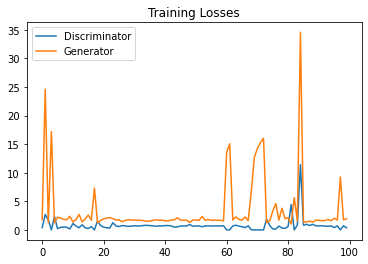

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [0]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

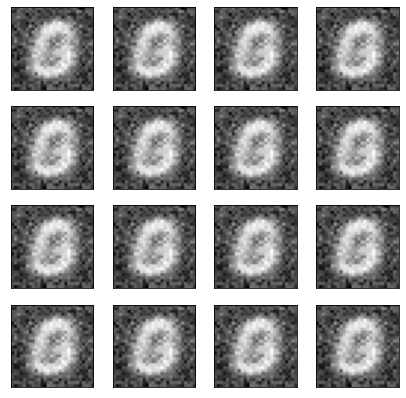

In [0]:
_ = view_samples(-1, samples)

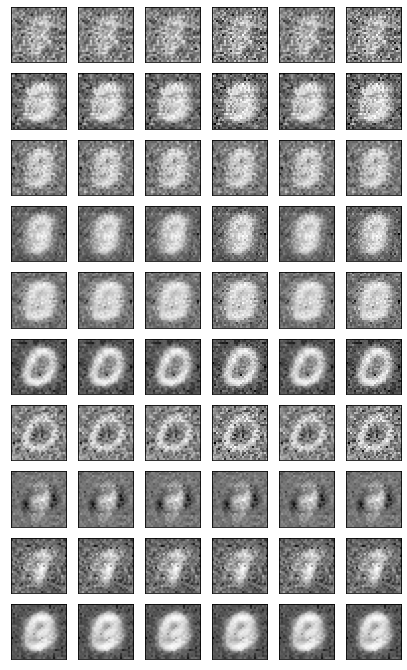

In [0]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [0]:
#training for modified minimax generator loss function
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(G2_loss, var_list=g_vars)

In [0]:
batch_size = 100
epochs = 100
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(train_images.shape[0]//batch_size):
            #batch = mnist.train.next_batch(batch_size)
            batch = train_images[(batch_size*ii):(batch_size*(ii+1))]
            # Get images, reshape and rescale to pass to D
            batch_images = batch.reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(D_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = G2_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size,reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.2518... Generator Loss: 1.3690
Epoch 2/100... Discriminator Loss: 0.2614... Generator Loss: 10.0077
Epoch 3/100... Discriminator Loss: 7.6031... Generator Loss: 1.9224
Epoch 4/100... Discriminator Loss: 0.0337... Generator Loss: 1.6238
Epoch 5/100... Discriminator Loss: 0.0326... Generator Loss: 1.5942
Epoch 6/100... Discriminator Loss: 5.1051... Generator Loss: 0.2184
Epoch 7/100... Discriminator Loss: 0.0386... Generator Loss: 1.4475
Epoch 8/100... Discriminator Loss: 1.2630... Generator Loss: 0.2994
Epoch 9/100... Discriminator Loss: 0.1749... Generator Loss: 1.2098
Epoch 10/100... Discriminator Loss: 1.9075... Generator Loss: 2.4778
Epoch 11/100... Discriminator Loss: 1.9863... Generator Loss: 0.2275
Epoch 12/100... Discriminator Loss: 0.2370... Generator Loss: 0.7254
Epoch 13/100... Discriminator Loss: 0.4464... Generator Loss: 0.6008
Epoch 14/100... Discriminator Loss: 0.7342... Generator Loss: 0.4385
Epoch 15/100... Discriminator Loss: 0.4322

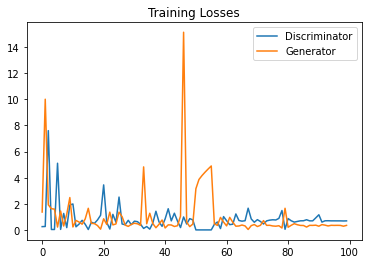

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

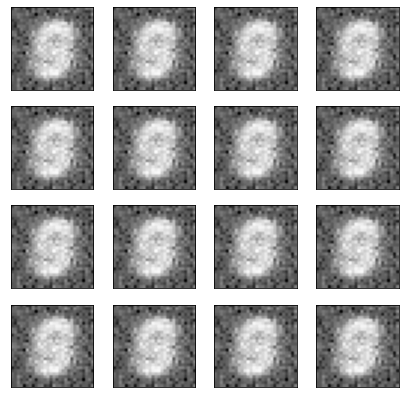

In [0]:
_ = view_samples(-1, samples)

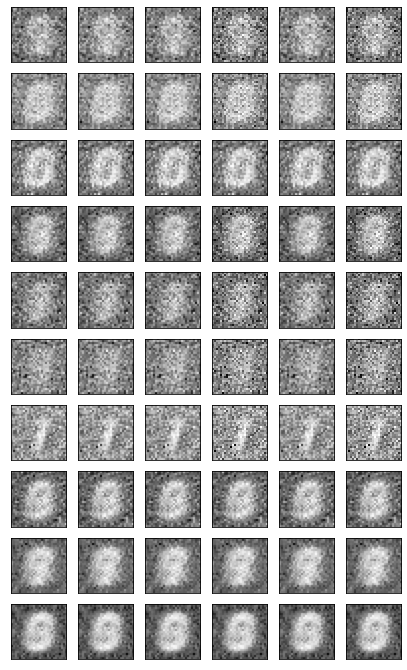

In [0]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

##after trying both loss function for the generator, I found that modified minimax function works better, as the generator loss in the minimax function was above 1, but in modified minimax function, it saturates below 0.5. I Found also from Graph that while training the generator loss function in the first case was always bigger than the discrimantor loss function, while in the second case the generator loss function was smaller than the discrimator loss function. overall, modified function gave overall better performance than regular minimax, as using minimax function can get GAN network to be stucked at the early training as the discrimnator job is easy. so modified minimax works by maximize log D(G(z)) instead of minimzing log (1-D(G(z)))